## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a person who is choosing a dress for Hari Raya. It turns out that the person is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue">
    ANSWER:</span>

Cross-entropy loss. Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    



![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary
from torchvision import transforms
###############################################
######## THE REST OF YOUR CODES HERE ##########
###############################################
batch_size=32
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5,0.5,0.5)),
     transforms.Resize(32)])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model=Classifier()
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_acc = 0.0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size
        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
    return model, history
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch: 1/10
Epoch : 000, Training: Loss: 1.0532, Accuracy: 61.5750%, 
		Validation : Loss : 0.6135, Accuracy: 76.7600%, Time: 30.3305s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.5360, Accuracy: 79.9283%, 
		Validation : Loss : 0.5100, Accuracy: 81.2100%, Time: 22.4226s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4543, Accuracy: 83.2117%, 
		Validation : Loss : 0.4931, Accuracy: 81.3000%, Time: 23.7744s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4086, Accuracy: 84.9933%, 
		Validation : Loss : 0.4317, Accuracy: 83.8800%, Time: 22.5765s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.3761, Accuracy: 86.1183%, 
		Validation : Loss : 0.4047, Accuracy: 85.1600%, Time: 22.5784s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3520, Accuracy: 86.9317%, 
		Validation : Loss : 0.3877, Accuracy: 85.9300%, Time: 22.5216s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3346, Accuracy: 87.5733%, 
		Validation : Loss : 0.3701, A

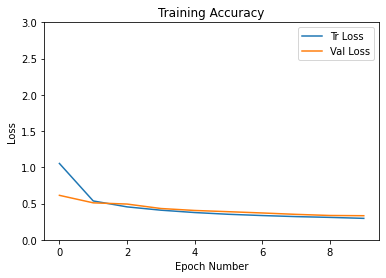

In [ ]:
#training history
history = np.array(history)
plt.plot(history[:,0:2])
plt.title('Training Accuracy')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

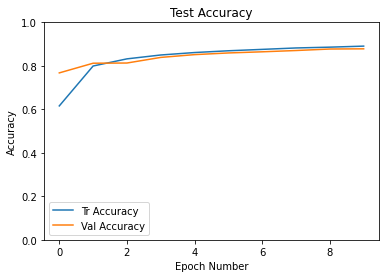

In [ ]:
#test accuracy
plt.plot(history[:,2:4])
plt.title('Test Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################
model_tf = models.resnet18(pretrained=True)
num_ftrs = model_tf.fc.in_features
#num_ftrs = 4096
model_tf.fc = nn.Linear(num_ftrs, 10)
model_tf = model_tf.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_tf = optim.SGD(model_tf.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
trained_model, history = train_and_validate(model_tf, criterion, optimizer_tf, num_epochs)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.4167, Accuracy: 85.3250%, 
		Validation : Loss : 0.2840, Accuracy: 89.8100%, Time: 42.0659s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.2597, Accuracy: 90.5717%, 
		Validation : Loss : 0.2433, Accuracy: 91.2600%, Time: 42.3877s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2202, Accuracy: 91.9733%, 
		Validation : Loss : 0.2234, Accuracy: 91.8100%, Time: 40.9735s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1902, Accuracy: 93.0233%, 
		Validation : Loss : 0.2372, Accuracy: 91.5900%, Time: 41.0989s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1706, Accuracy: 93.7267%, 
		Validation : Loss : 0.2295, Accuracy: 92.0500%, Time: 41.1608s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1525, Accuracy: 94.3317%, 
		Validation : Loss : 0.2204, Accuracy: 92.3900%, Time: 41.0410s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1387, Accuracy: 94.9400%, 
		Validation : Loss : 0.2245, Accuracy: 92.3300%, Time: 44.9474s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1259, Accura

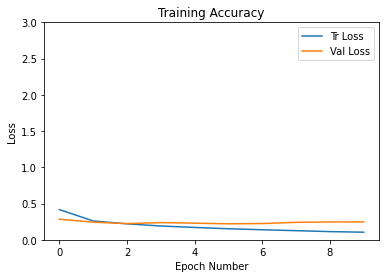

In [ ]:
#training history
history = np.array(history)
plt.plot(history[:,0:2])
plt.title('Training Accuracy')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

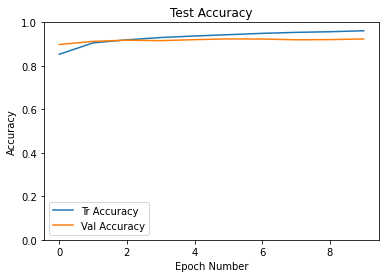

In [ ]:
#test accuracy
plt.plot(history[:,2:4])
plt.title('Test Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are:
    </span>

1. Use better pretrained model
2. Change learning rate

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [ ]:
###############################################
###############YOUR CODES HERE ################
###############################################
model_tf = models.googlenet(pretrained=True)
num_ftrs = model_tf.fc.in_features
model_tf.fc = nn.Linear(num_ftrs, 10)
model_tf = model_tf.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_tf = optim.SGD(model_tf.parameters(), lr=0.05, momentum=0.9)
num_epochs = 10
trained_model, history = train_and_validate(model_tf, criterion, optimizer_tf, num_epochs)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 1.1429, Accuracy: 66.4050%, 
		Validation : Loss : 0.5734, Accuracy: 81.0600%, Time: 77.7797s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.5283, Accuracy: 80.9133%, 
		Validation : Loss : 0.5043, Accuracy: 82.4900%, Time: 76.5753s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4321, Accuracy: 84.5700%, 
		Validation : Loss : 0.5374, Accuracy: 81.6200%, Time: 76.7107s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3920, Accuracy: 85.9217%, 
		Validation : Loss : 0.4189, Accuracy: 84.9000%, Time: 75.9670s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.3488, Accuracy: 87.4683%, 
		Validation : Loss : 0.3799, Accuracy: 86.9600%, Time: 76.3437s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3103, Accuracy: 88.8500%, 
		Validation : Loss : 0.2993, Accuracy: 89.3400%, Time: 75.6814s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3781, Accuracy: 86.1833%, 
		Validation : Loss : 0.4487, Accuracy: 84.1900%, Time: 76.1419s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3771, Accura

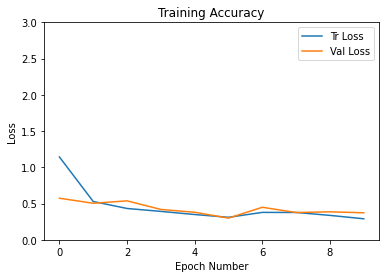

In [ ]:
#training history
history = np.array(history)
plt.plot(history[:,0:2])
plt.title('Training Accuracy')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

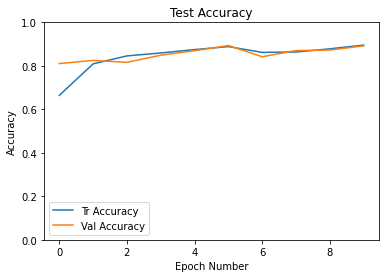

In [ ]:
#test accuracy
plt.plot(history[:,2:4])
plt.title('Test Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    Your answer here </span>

Yes. The use of a better model and some tweaks on the parameters like learning rate might be the reason behind the increase of the accuracy improvement.

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
    Your answer here </span>

1. Random rotation
2. Random horizontal flip

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [ ]:
###############################################
##############YOUR CODES HERE #################
###############################################
image_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
        transforms.Resize(32)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
        transforms.Resize(32)
    ])
}
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=image_transform['train'])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=image_transform['test'])
data={'train':trainset,
    'test':testset
}
trainloader = torch.utils.data.DataLoader(data['train'], batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(data['test'], batch_size=batch_size,
                                         shuffle=False, num_workers=2)
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)
trained_model, history = train_and_validate(model_tf, criterion, optimizer_tf, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.5413, Accuracy: 80.0867%, 
		Validation : Loss : 0.3702, Accuracy: 86.4900%, Time: 124.1092s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4945, Accuracy: 81.5933%, 
		Validation : Loss : 0.5245, Accuracy: 83.6200%, Time: 122.4763s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.4628, Accuracy: 82.7783%, 
		Validation : Loss : 0.5004, Accuracy: 84.3800%, Time: 123.5496s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4449, Accuracy: 83.4333%, 
		Validation : Loss : 0.4807, Accuracy: 85.2400%, Time: 122.6466s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.6283, Accuracy: 76.2850%, 
		Validation : Loss : 0.4675, Accuracy: 82.4800%, Time: 121.8361s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.5131, Accuracy: 80.7750%, 
		Validation : Loss : 0.5162, Accuracy: 82.8600%, Time: 121.2889s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.4617, Accuracy: 82.8633%, 
		Validation : Loss : 0.3781, Accuracy: 86.2500%, Time: 120.8817s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.4406,

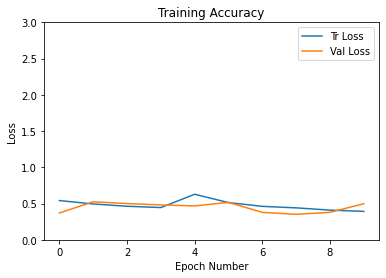

In [ ]:
#training history
history = np.array(history)
plt.plot(history[:,0:2])
plt.title('Training Accuracy')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

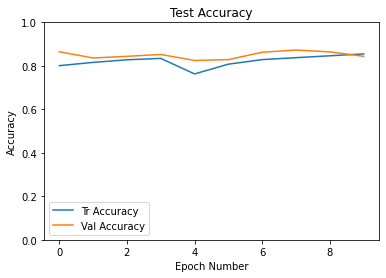

In [ ]:
#test accuracy
plt.plot(history[:,2:4])
plt.title('Test Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).